参考：https://www.tensorflow.org/get_started/mnist/pros 和 http://www.tensorfly.cn/tfdoc/tutorials/mnist_pros.html

### 预备知识
1：熟悉高等代数基础知识：向量、矩阵；矩阵乘法；线性变换  
2：熟悉ML基础概念：了解损失函数的作用及常见损失函数；了解常见最优化方法  
3：熟悉深度学习的基础概念：熟悉CNN、卷积、池化、dropout、常见激活函数

### 获取数据集
数据集的下载可能会报错;因为默认的https://storage.googleapis.com/cvdf-datasets/mnist 无法访问，有两种解决方法

a)修改site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py
将
SOURCE_URL = 'https://storage.googleapis.com/cvdf-datasets/mnist/'  改为
SOURCE_URL = 'http://yann.lecun.com/exdb/mnist/'

b)在http://yann.lecun.com/exdb/mnist/ 中先下载好如下四个文件，存放在jupyter启动的目录下（如本例启动目录在/opt/pythonenv，则在/opt/pythonenv/MNIST_data/目前下存放如下4个数据文件）
MNIST_data/train-images-idx3-ubyte.gz
MNIST_data/train-labels-idx1-ubyte.gz
MNIST_data/t10k-images-idx3-ubyte.gz
MNIST_data/t10k-labels-idx1-ubyte.gz


In [1]:
import tensorflow.examples.tutorials.mnist.input_data as input_data
mnist = input_data.read_data_sets("/opt/pythonenv/Tensorflow入门/dataset/MNIST_data/", one_hot=True)  ##mnist是Datasets 类型，Datasets = collections.namedtuple('Datasets', ['train', 'validation', 'test'])

Extracting /opt/pythonenv/Tensorflow入门/dataset/MNIST_data/train-images-idx3-ubyte.gz
Extracting /opt/pythonenv/Tensorflow入门/dataset/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /opt/pythonenv/Tensorflow入门/dataset/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /opt/pythonenv/Tensorflow入门/dataset/MNIST_data/t10k-labels-idx1-ubyte.gz


### 运行TensorFlow的InteractiveSession
Tensorflow依赖于一个高效的C++后端来进行计算。与后端的这个连接叫做session。一般而言，使用TensorFlow程序的流程是先创建一个图，然后在session中启动它。  

这里，我们使用更加方便的InteractiveSession类。通过它，你可以更加灵活地构建你的代码。它能让你在运行图的时候，插入一些计算图，这些计算图是由某些操作(operations)构成的。这对于工作在交互式环境中的人们来说非常便利，比如使用IPython。如果你没有使用InteractiveSession，那么你需要在启动session之前构建整个计算图，然后启动该计算图。

In [2]:
import tensorflow as tf
tf.set_random_seed(35)
sess = tf.InteractiveSession()

### 定义占位符
输入图像和目标输出类别

In [3]:
x = tf.placeholder(tf.float32, shape=[None, 784]) ##使用占位符placeholder，第一维是记录，None代表长度不确定，第二维是图片的特征，每个图片是28*28=784
y_ = tf.placeholder(tf.float32, shape=[None, 10])   ##图片实际分类


### 权重初始化


为了创建这个模型，我们需要创建大量的权重和偏置项。这个模型中的权重在初始化时应该加入少量的噪声来打破对称性以及避免0梯度。由于我们使用的是ReLU神经元，因此比较好的做法是用一个较小的正数来初始化偏置项，以避免神经元节点输出恒为0的问题（dead neurons）。为了不在建立模型的时候反复做初始化操作，我们定义两个函数用于初始化。

In [4]:

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)   ##生成shape指定形状的，均值为0，stddev代表标注差的正态分布数据，作为初始权重
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)  ##生成shape指定形状的，值为0.1的偏置数据
  return tf.Variable(initial)

### 卷积和池化 


TensorFlow在卷积和池化上有很强的灵活性。我们怎么处理边界？步长应该设多大？在这个实例里，我们会一直使用vanilla版本。我们的卷积使用1步长（stride size），0边距（padding size）的模板，保证输出和输入是同一个大小。我们的池化用简单传统的2x2大小的模板做max pooling。为了代码更简洁，我们把这部分抽象成一个函数。

In [5]:
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')  ##步长设为1，strides=[batch, height, width, channels]

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')   ##ksize表示各个维度池化窗口的大小，若某个维度取值为1，则表示在该维度上不进行池化

### 第一层卷积

现在我们可以开始实现第一层了。它由一个卷积接一个max pooling完成。卷积在每个5x5的patch中算出32个特征。卷积的权重张量形状是[5, 5, 1, 32]，前两个维度是patch的大小，接着是输入的通道数目，最后是输出的通道数目。 而对于每一个输出通道都有一个对应的偏置量。


In [6]:
W_conv1 = weight_variable([5, 5, 1, 32])  ##1是输入通道数，32是输出通道数；
b_conv1 = bias_variable([32])

In [7]:
x_image = tf.reshape(x, [-1,28,28,1])  ##tensor变换为参数shape为[-1,28,28,1]的形式，-1代表的含义是不用我们自己指定这一维的大小，函数会自动计算;
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)  ##使用relu激活函数；same方式：卷积后是28*28特征，valid方式：28-5+1=24；卷积后是24*24特征
h_pool1 = max_pool_2x2(h_conv1)  ##池化；池化窗口是2*2，步长是2*2；池化后是28/2=14; 14*14的特征


### 第二层卷积
为了构建一个更深的网络，我们会把几个类似的层堆叠起来。第二层中，每个5x5的patch会得到64个特征。

In [8]:
W_conv2 = weight_variable([5, 5, 32, 64])  ##还是5*5的卷积核，输入通道32，输出通道64
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)  ##池化层作为输入；same方式卷积后是14*14；
h_pool2 = max_pool_2x2(h_conv2) ##池化；池化窗口是2*2，步长是2*2；池化后是14/2=7; 7*7的特征


### 密集连接层

现在，图片尺寸减小到7x7，我们加入一个有1024个神经元的全连接层，用于处理整个图片。我们把池化层输出的张量reshape成一些向量，乘上权重矩阵，加上偏置，然后对其使用ReLU。



In [9]:
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])  ###64个通道合并为一个向量
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

### Dropout
为了减少过拟合，我们在输出层之前加入dropout。我们用一个placeholder来代表一个神经元的输出在dropout中保持不变的概率。这样我们可以在训练过程中启用dropout，在测试过程中关闭dropout。 TensorFlow的tf.nn.dropout操作除了可以屏蔽神经元的输出外，还会自动处理神经元输出值的scale。所以用dropout的时候可以不用考虑scale。



In [10]:
keep_prob = tf.placeholder("float")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)


### 输出层

最后，我们添加一个softmax层，就像前面的单层softmax regression一样。



In [11]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

### 训练和评估模型

这个模型的效果如何呢？

为了进行训练和评估，我们使用与之前简单的单层SoftMax神经网络模型几乎相同的一套代码，只是我们会用更加复杂的ADAM优化器来做梯度最速下降，在feed_dict中加入额外的参数keep_prob来控制dropout比例。然后每100次迭代输出一次日志。

In [12]:
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

sess.run(tf.global_variables_initializer())
for i in range(500):
  batch = mnist.train.next_batch(50)  ##给个批次50个样本
  if i%100 == 0:  ##每100次迭代输出当次训练样本误差
    train_accuracy = accuracy.eval(session=sess,feed_dict={
        x:batch[0], y_: batch[1], keep_prob: 1.0})
    print ("step %d, training accuracy %g"%(i, train_accuracy))
  train_step.run(session=sess,feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})  ##训练，dropout节点保留比例为0.5

##输出测试误差
print ("test accuracy %g"%accuracy.eval(session=sess,feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))  

step 0, training accuracy 0.16
step 100, training accuracy 0.78
step 200, training accuracy 0.86
step 300, training accuracy 0.98
step 400, training accuracy 0.84
test accuracy 0.9508


## 总结
以上手写数字识别CNN模型构建流程如下：
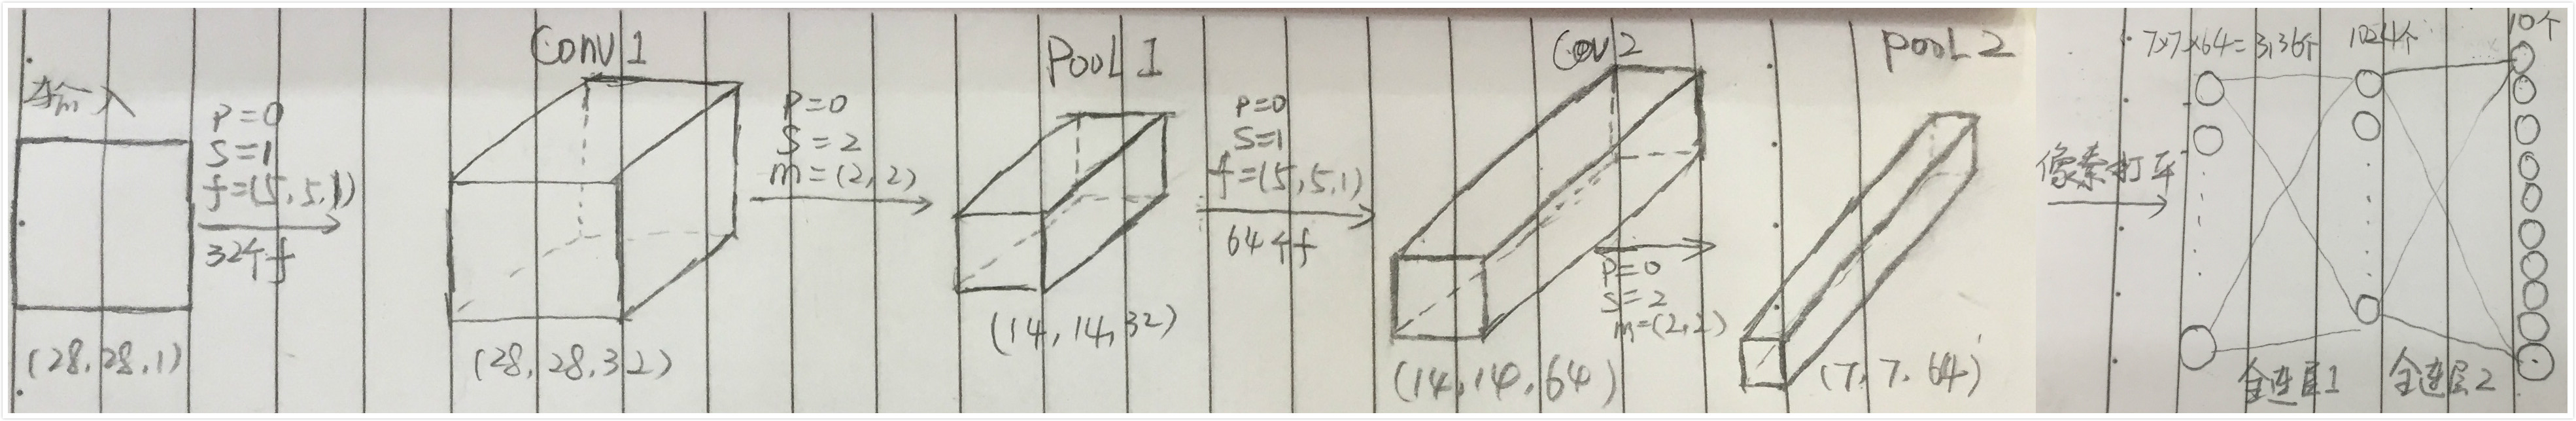

注：上图第二层卷积滤波器是（5，5，32）不是（5，5，1），此处有笔误